In [2]:
import numpy as np
import copy

sqrt_2_pi = np.sqrt(2 * np.pi)

class Agent(object):
    def __init__(self, resource_size):
        self._means = np.random.uniform(size=resource_size)
        # self._means = np.array([1.,5.])
        self._sigmas = np.ones(resource_size) * 4
        self._mutability = np.random.uniform(size=resource_size)
        self._energy = 0
        self._reproduction_threshold = 3
        self._mutation_level_means = 0.1
        self._mutation_level_sigmas = 0.1
        self._mutation_level_repro = 0.1
        self._gen = 1
        self._hls = np.array([0.5, 0.0, 0.5])
        
        print(self._means)
        print(self._sigmas)

    def extract_energy(self, resources):
        # env is list of resources
        dist_squared = np.square(self._means - resources)
        energy = (
                (np.exp(-dist_squared / (2*self._sigmas*self._sigmas)))
                / (self._sigmas * sqrt_2_pi))
        # print('energy', dist_squared, self._sigmas, energy)
        self._energy += energy.sum()

    def reproduce(self, agents, pos):
        if self._energy >= self._reproduction_threshold:
            if np.random.uniform() > 0.5:
                idx = pos - 1
            else:
                idx = pos + 1
            if (agents[idx] is None
                or agents[idx]._energy < self._energy):
                agents[idx] = self._make_offspring()

    def _make_offspring(self):
        clone = copy.deepcopy(self)
        clone.mutate()
        clone._energy /= 2
        clone._gen += 1
        self._energy /= 2
        return clone

    def mutate(self):
        self._means += (np.random.normal(size=self._means.shape)
                * self._mutation_level_means)
        
        self._sigmas += (np.random.normal(size=self._sigmas.shape)
                * self._mutation_level_sigmas)
        too_low = self._sigmas < 1.0
        self._sigmas[too_low] = 1.0
        
        self._reproduction_threshold += (np.random.normal()
                * self._mutation_level_repro)
        self._reproduction_threshold = max(min(self._reproduction_threshold, 10.), 1.)
        
        mutation_level = 0.01
        self._hls += (np.array([mutation_level, 0.0, mutation_level]) *
                      np.random.normal(size=self._hls.shape))
        too_low = self._hls < 0.
        self._hls[too_low] = 0.0
        too_high = self._hls > 1.
        self._hls[too_high] = 1.0

    def gen_to_char(self):
        chars = list('.:-=+*#%@')
        # '.,-+*oO$0#$@
        return chars[self._gen % len(chars)]

    def energy_to_char(self):
        return str(int(self._energy))
    
    @property
    def gen(self):
        return self._gen
    
    def hls(self):
        return np.array([0., self._energy/10., 0.]) + self._hls


def step_world(world, incoming_resource, agents):
    depth = 0
    world[depth] = incoming_resource
    # print('incoming', incoming_resource)
    for pos in range(world.shape[1]):
        agent = agents[pos]
        resource = world[depth][pos]
        if agent is not None:
          world[depth + 1][pos] = agent.extract_energy(resource)
        else:
          world[depth + 1][pos] = resource
    for pos in range(1, world.shape[1] - 1):
        agent = agents[pos]
        if agent is not None:
            agent.reproduce(agents, pos)
            # print(agent._sigmas)
            # print(agent._means)


def show(world, agents):
    out = ''
    for i in range(world.shape[1]):
        if agents[i] is not None:
            out += agents[i].gen_to_char()
        else:
            out += ' '
    out += ' | '
    for i in range(world.shape[1]):
        if agents[i] is not None:
            out += agents[i].energy_to_char()
        else:
            out += ' '
    print(out)
    
def get_gens(world, agents):
    out = []
    for i in range(world.shape[1]):
        if agents[i] is not None:
            out.append(agents[i].gen)
        else:
            out.append(0)
    return np.array(out)

        

In [18]:
land_size = 100
num_resources = 2
history = 10

resources = np.zeros(num_resources)
resources[0] = 1.
resources[1] = 5.

world = np.zeros((history, land_size, num_resources))
agents = [None for _ in range(land_size)]
agents[int(land_size/2)] = Agent(num_resources)

vis = np.zeros((1,land_size,))

#show(world, agents)
for _ in range(1000):
    step_world(world, resources, agents)
    #show(world, agents)
    gens = get_gens(world, agents).reshape(1,land_size)
    vis = np.append(vis, gens, axis=0)


[ 0.10719642  0.97527067]
[ 4.  4.]


In [21]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,100))
plt.imshow(vis)
plt.show()

MemoryError: In RendererAgg: Out of memory

In [12]:
vis[3]


array([ 0.,  0.,  1.,  0.])

hello


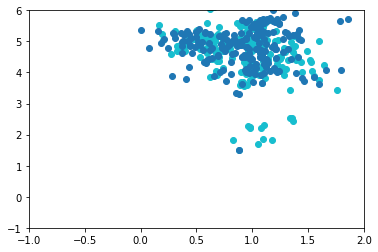

In [38]:
def get_data(agents):
    means = []
    sigmas = []
    for agent in agents:
        if agent is not None:
            means.append(agent._means)
            sigmas.append(agent._sigmas)
    return means, sigmas
                         
means, sigmas = np.array(get_data(agents))

plt.scatter(means[:,0], means[:,1])
plt.show()

In [31]:
means[:,0]
# means[:,1]

array([ 0.80823174,  1.03204881,  0.99202306,  0.61227175])

In [35]:
make_video = True
visualise = 'generations'
visualise = 'means'

def get_data(agents):
    means = []
    
    for agent in agents:
        if agent is not None:
            means.append(agent._means)
    return means

if make_video:
    import matplotlib
    import matplotlib.pyplot as plt
    import datetime
    print(str(datetime.datetime.now()))

    matplotlib.use("Agg")
    import matplotlib.animation as manimation
    FFMpegWriter = manimation.writers['ffmpeg']
    metadata = dict(title='Movie Test', artist='Matplotlib',
                    comment='Movie support!')
    writer = FFMpegWriter(fps=15, metadata=metadata)

    fig = plt.figure()

    land_size = 200
    num_resources = 2
    history = 10

    resources = np.zeros(num_resources)
    resources[0] = 1.
    resources[1] = 5.

    world = np.zeros((history, land_size, num_resources))
    agents = [None for _ in range(land_size)]
    agents[int(land_size/2)] = Agent(num_resources)

    vis = np.zeros((200,land_size,))
    
    video_name = visualise + "_loki.mp4"

    with writer.saving(fig, video_name, 100):
        for i in range(4000):
            step_world(world, resources, agents)
            if visualise == 'means':             
                if i % 100 == 0:
                    means = np.array(get_data(agents))
                    scat.remove()
                    scat = plt.scatter(means[:,0], means[:,1])
                    plt.xlim((-1, resources[0]+1))
                    plt.ylim((-1, resources[1]+1))
                    writer.grab_frame()
            elif visualise == 'generations':
                gens = get_gens(world, agents)
                vis[0] = gens
                vis = np.roll(vis, 1, axis=0)
                plt.imshow(vis)
                writer.grab_frame()
                    
    print(str(datetime.datetime.now()))


2019-06-03 22:15:26.712635
[ 0.19010114  0.43442165]
[ 4.  4.]


/usr/lib/python3/dist-packages/matplotlib/__init__.py:1403: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


2019-06-03 22:17:11.758964


In [36]:
import io
import base64
from IPython.display import HTML

video = io.open(video_name, 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))

In [39]:
from scipy.stats import multivariate_normal

x, y = np.mgrid[-1:2:.1, -1:6:.4]
pos = np.dstack((x, y))
rv = multivariate_normal(means[:2], sigmas[:2])
fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
ax2.contourf(x, y, rv.pdf(pos))

ValueError: Array 'mean' must be a vector of length 4.

In [48]:
means[:,0]

array([ 0.88007565,  1.20288161,  0.85000778,  0.90560877,  0.86547347,
        1.17500627,  1.31752153,  1.19332048,  1.07321   ,  1.08442132,
        1.2424261 ,  1.16178112,  1.34858372,  1.40928138,  0.96801699,
        1.12995824,  1.00181249,  0.97946274,  0.93504885,  1.00492882,
        0.98295967,  1.39484044,  1.21926815,  0.20728494,  0.48419   ,
        0.56026327,  0.37328779,  0.4419349 ,  1.13896344,  1.55171044,
        1.44799987,  1.46018741,  1.59797769,  0.36734819,  0.63716069,
        0.72996067,  0.7282818 ,  0.71931193,  0.443404  ,  0.81588909,
        0.69812044,  1.27916769,  1.36180304,  0.99017753,  1.06602261,
        1.33316764,  1.40473041,  1.29195537,  1.42310028,  0.41000601,
        0.28283446,  0.43438249,  0.81268335,  0.64007736,  0.60903892,
        0.69195113,  0.97555266,  0.75276386,  0.62510146,  0.51312772,
        0.37211392,  0.46172543,  0.91098658,  1.00719084,  0.85534301,
        0.885975  ,  0.56573504,  0.58524175,  0.59463077,  0.79

In [ ]:
make_picture = False
if make_picture:
    import datetime
    from PIL import Image

    print(str(datetime.datetime.now()))

    land_size = 200
    num_resources = 2
    history = 10

    resources = np.zeros(num_resources)
    resources[0] = 1.
    resources[1] = 5.

    world = np.zeros((history, land_size, num_resources))
    agents = [None for _ in range(land_size)]
    agents[int(land_size/2)] = Agent(num_resources)

    vis = np.zeros((100,land_size,3))

    for t in range(100):
        step_world(world, resources, agents)

        for pos in range(world.shape[1]):
            if agents[pos] is not None:
                vis[t][pos] = agents[pos].hls()

    img = Image.fromarray(vis)
    img.save('loki_test.png'
    print(str(datetime.datetime.now()))


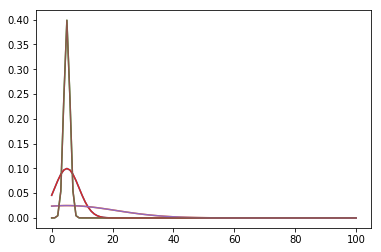

In [47]:
# blue 
xx = np.array(range(101))
centre = 5
sigma = 4.0
nrbf = np.exp(-(np.square(xx - centre) / (2*sigma*sigma))) /(sigma * np.sqrt(2 * np.pi))
plt.plot((nrbf))
sigma = 16
nrbf = np.exp(-(np.square(xx - centre) / (2*sigma*sigma)))  /(sigma * np.sqrt(2 * np.pi))
plt.plot((nrbf))
sigma = 1
nrbf = np.exp(-(np.square(xx - centre) / (2*sigma*sigma)))  /(sigma * np.sqrt(2 * np.pi))
plt.plot((nrbf))
plt.show()

In [ ]:
aa = np.array([10, 20])
mm = np.array([11, 15])
dist = aa - mm

ss = np.array([1, 1])
print(np.exp(-(np.square(dist)) / (2*ss*ss)) /(ss * np.sqrt(2 * np.pi)))
ss = np.array([4, 4])
print(np.exp(-(np.square(dist)) / (2*ss*ss)) /(ss * np.sqrt(2 * np.pi)))
ss = np.array([4, 1])
#ss = np.array([1, 1])
print(np.exp(-(np.square(dist)) / (2*ss*ss)) /(ss * np.sqrt(2 * np.pi))